In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
phase_data_full = pd.read_csv('/home/idies/workspace/Storage/matsdata/persistent/Phase_Calc_Data.csv')
phase_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47412 entries, 0 to 47411
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   el0           47412 non-null  object 
 1   el1           47412 non-null  object 
 2   el2           47412 non-null  object 
 3   el3           47412 non-null  object 
 4   x0            47412 non-null  float64
 5   x1            47412 non-null  float64
 6   x2            47412 non-null  float64
 7   x3            47412 non-null  float64
 8   phase_1_name  47412 non-null  object 
 9   phase_2_name  19198 non-null  object 
 10  phase_3_name  4822 non-null   object 
 11  phase_4_name  585 non-null    object 
 12  phase_5_name  3 non-null      object 
 13  phase_1_frac  47412 non-null  float64
 14  phase_2_frac  19198 non-null  float64
 15  phase_3_frac  4822 non-null   float64
 16  phase_4_frac  585 non-null    float64
 17  phase_5_frac  3 non-null      float64
dtypes: float64(9), object(9)
m

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Cleaning/Transformations

### Cleaning the Data:
There are a few attributes of the dataset that aren't particularly relevant/useful, and those are the phase_x_fracs. It doesn't really matter how much of each phase is present, when all I really care about is which phases are present. Also, not all combinations of elements yield 3, 4, or 5 phases in equilibrium, so those need to be filled in wth 'none'.

### Transforming the Data:
I plan to have each node in the input layer of my neural network correspond to the amount of one of the 10 possible elements that show up in the dataset. Some Pandas magic needs to happen so that the column elements are reformatted to fit the above description.

Once the dataset is all nice and formatted, the dataset is split into a train set and test set. These are turned into more tensorflow friendly formats using from_tensor_slices() from tf.data.Dataset, before finally getting batched.

In [3]:
# Class definitions for data cleaning pipeline

class dropAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, drop_phase_fracs = True): # no *args or **kwargs
        self.drop_phase_fracs = drop_phase_fracs
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        if self.drop_phase_fracs:
            X.drop(X.iloc[:, 13:18], inplace = True, axis = 1) #drop all phase_{x}_frac
            return X
        else:
            return X
        
class cleanupNan(BaseEstimator, TransformerMixin):
    def __init__(self, dropped_phase_fracs = True):
        self.dropped_phase_fracs = dropped_phase_fracs
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.fillna('none', inplace = True)
        return X

In [4]:
# The lists of columns that will be used for ColumnTransformer
all_attribs = list(phase_data_full)
feature_attribs = ['el0', 'el1', 'el2', 'el3']
label_attribs = ['phase_1_name', 'phase_2_name', 'phase_3_name', 'phase_4_name', 'phase_5_name']

# Get the unique feature categories
unique_features_list = pd.unique(phase_data_full[feature_attribs].values.ravel('K')).tolist()
print('Elements list:', unique_features_list)

# Get the unique labels for LabelBinarizer()
unique_labels = pd.unique(phase_data_full[label_attribs].values.ravel('K'))
unique_labels_list = unique_labels.tolist()
cleaned_unique_labels_list = [x for x in unique_labels_list if x == x]
print('Features list:', cleaned_unique_labels_list)
      
clean_pipeline = Pipeline([
    ('dropper', dropAttributes()),
    ('cleaner', cleanupNan()),
])

phase_data_clean = clean_pipeline.fit_transform(phase_data_full)
phase_data_clean.head(5)

Elements list: ['AL', 'FE', 'MN', 'NB', 'NI', 'TA', 'V', 'MO', 'CR', 'TI']
Features list: ['LIQUID', 'AL3M_D022', 'AL2TI', 'ALTI', 'ALM_D019', 'HCP_A3', 'AL11CR2', 'BCC_B2', 'AL9CR4_L', 'AL8CR5_L', 'ALCR2', 'AL4CR', 'CUB_A15', 'AL4MO', 'AL8MO3', 'FCC_A1', 'LAVES_C15', 'LAVES_C14', 'FETI', 'AL2FE', 'AL5FE2', 'AL13FE4', 'AL5MO', 'CR3SI_A15', 'SIGMA', 'CUB_A13', 'CBCC_A12', 'CR3MN5', 'AL8MN5_D810', 'AL11MN4', 'AL4MN', 'CRSI2', 'AL6MN', 'ALPHA_TIMN', 'AL3TA2_L', 'NI2V', 'NI3V', 'NI2V7', 'AL13CR2']


,el0,el1,el2,el3,x0,x1,x2,x3,phase_1_name,phase_2_name,phase_3_name,phase_4_name,phase_5_name
0,AL,MO,CR,TI,0.9,0.0,0.0,0.1,LIQUID,AL3M_D022,none,none,none
1,AL,MO,CR,TI,0.8,0.0,0.0,0.2,LIQUID,AL3M_D022,none,none,none
2,AL,MO,CR,TI,0.7,0.0,0.0,0.3,AL3M_D022,AL2TI,none,none,none
3,AL,MO,CR,TI,0.6,0.0,0.0,0.4,AL2TI,ALTI,none,none,none
4,AL,MO,CR,TI,0.5,0.0,0.0,0.5,ALTI,none,none,none,none


In [5]:
data_copy = phase_data_clean.copy()

In [6]:
#Rearrange dataframe to be more compatible with models.
base_df = data_copy.iloc[:, 0:8] #the columns el0 to x3
rearranged_features = pd.wide_to_long(base_df.reset_index(), ['el', 'x'], 'index', 'No')\
.reset_index(level=1, drop=True)\
.set_index('el', append=True)['x']\
.unstack()\
.fillna(0.0)

In [7]:
phase_label_data = data_copy[label_attribs].copy()
unique_labels = pd.unique(phase_label_data[label_attribs].values.ravel('K')).tolist()
cleaned_unique_labels = [x for x in unique_labels if x == x] #take advantage of fact that nan == nan evals to false

# Fit label binarizer to the phase names
lb = LabelBinarizer()
lb.fit(cleaned_unique_labels)
lb.classes_

array(['AL11CR2', 'AL11MN4', 'AL13CR2', 'AL13FE4', 'AL2FE', 'AL2TI',
       'AL3M_D022', 'AL3TA2_L', 'AL4CR', 'AL4MN', 'AL4MO', 'AL5FE2',
       'AL5MO', 'AL6MN', 'AL8CR5_L', 'AL8MN5_D810', 'AL8MO3', 'AL9CR4_L',
       'ALCR2', 'ALM_D019', 'ALPHA_TIMN', 'ALTI', 'BCC_B2', 'CBCC_A12',
       'CR3MN5', 'CR3SI_A15', 'CRSI2', 'CUB_A13', 'CUB_A15', 'FCC_A1',
       'FETI', 'HCP_A3', 'LAVES_C14', 'LAVES_C15', 'LIQUID', 'NI2V',
       'NI2V7', 'NI3V', 'SIGMA', 'none'], dtype='<U11')

In [8]:
phase_1_data = phase_label_data['phase_1_name']
phase_1_data.columns = 'phase1'

phase_2_data = phase_label_data['phase_2_name']
phase_2_data.columns = 'phase2'

phase_3_data = phase_label_data['phase_3_name']
phase_3_data.columns = 'phase3'

phase_4_data = phase_label_data['phase_4_name']
phase_4_data.columns = 'phase4'

phase_5_data = phase_label_data['phase_5_name']
phase_5_data.columns = 'phase5'
    
def binarizer(label_data):
    binarized_data = lb.transform(label_data)
    df_binarized_labels = pd.DataFrame(binarized_data, columns=[lb.classes_])
    return pd.concat([label_data, df_binarized_labels], axis = 1)

phase_1_data_enc = binarizer(phase_1_data)
phase_2_data_enc = binarizer(phase_2_data)
phase_3_data_enc = binarizer(phase_3_data)
phase_4_data_enc = binarizer(phase_4_data)
phase_5_data_enc = binarizer(phase_5_data)

full_encoded_labels = phase_1_data_enc + phase_2_data_enc + phase_3_data_enc + phase_4_data_enc + phase_5_data_enc

full_encoded_labels = full_encoded_labels.drop(['phase_1_name', 'phase_2_name', 'phase_3_name', 'phase_4_name', 'phase_5_name'], axis = 1)

In [9]:
# There's no point in anything being greater than 1 to indicate the presence of a phase
full_encoded_labels[full_encoded_labels != 0] = 1 

In [10]:
workable_dataset = pd.concat([rearranged_features, full_encoded_labels], axis = 1)
workable_dataset = workable_dataset.iloc[:, :-1]#no need for the 'none,' column, which is leftover from the encoding when there isn't a 4th or 5th phase
workable_dataset.head(2)

,AL,CR,FE,MN,MO,NB,NI,TA,TI,V,...,"(FCC_A1,)","(FETI,)","(HCP_A3,)","(LAVES_C14,)","(LAVES_C15,)","(LIQUID,)","(NI2V,)","(NI2V7,)","(NI3V,)","(SIGMA,)"
0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0,0,0,0,0,1,0,0,0,0


In [11]:
train_set, test_set = train_test_split(workable_dataset, test_size = 0.2, random_state=42)
X_train_set = train_set.iloc[:, 0:10]
y_train_set = train_set.iloc[:, 10:49]

In [12]:
full_dataset = tf.data.Dataset.from_tensor_slices((X_train_set.values, y_train_set.values))
full_dataset

<TensorSliceDataset shapes: ((10,), (39,)), types: (tf.float64, tf.int64)>

In [13]:
batched_dataset = full_dataset.batch(5000)
batched_dataset

<BatchDataset shapes: ((None, 10), (None, 39)), types: (tf.float64, tf.int64)>

## Training the Neural Network

Considering how bare-bones this dataset is I would be pretty impressed to get accuracies above 70%. Phase stability calculations usually take into account a lot more information than just the amount of each element available. The CALPHAD (CALculation of PHAse Diagrams) methodology uses literally all thermodynamic and kinetic information available to produce a phase diagram of multicomponent alloy systems. Meanwhile I just know the elements and their respective amounts in my hypothetical multicomponent system.

In [14]:
# NN with 1 hidden layer with 100 neurons

def get_1layer_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_dim=10, activation='relu'),
    tf.keras.layers.Dense(39, activation='sigmoid'),
  ])

  model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
  return model

In [15]:
model = get_1layer_model()
history = model.fit(batched_dataset, epochs = 80, verbose = 0)

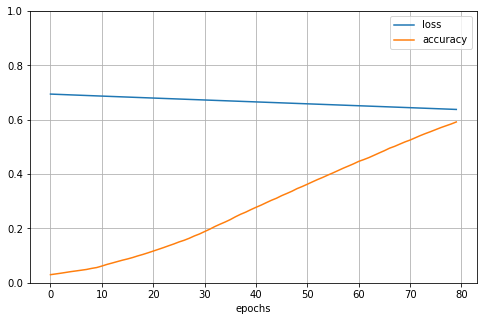

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1) #setting vertical range from 0-1.0
plt.xlabel('epochs')
plt.show()

In [17]:
X_test = test_set.iloc[:,0:10]
y_test = test_set.iloc[:,10:50]
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(5000)
model.evaluate(test_dataset)

2/2 [==============================] - 0s 19ms/step - loss: 0.6373 - accuracy: 0.5980


[0.6373143196105957, 0.5980175137519836]

In [18]:
# NN with 2 hidden layers, the first with 100 neurons and the second with 200 neurons

def get_2layer_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, input_dim=10, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(39, activation='sigmoid')
    ])
    
    model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
    return model

In [19]:
model2 = get_2layer_model()
history2 = model2.fit(batched_dataset, epochs = 80, verbose = 0)

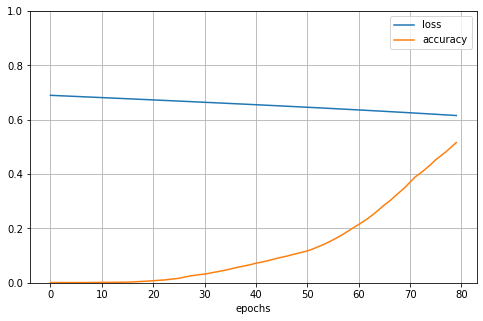

In [20]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1) #setting vertical range from 0-1.0
plt.xlabel('epochs')
plt.show()

In [21]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(5000)
model.evaluate(test_dataset)

2/2 [==============================] - 0s 16ms/step - loss: 0.6373 - accuracy: 0.5980


[0.6373143196105957, 0.5980175137519836]

## Hyperparameter Tuning

Instead of spending all day guessing and testing the right hyperparameters, I can have sklearn explore the hyperparameter space (guess and test) for me. To do this, I wrap the Keras models in objects that emulate sklearn regressors. First, I create a build_model() function that builds and compiles a Keras model with a given set of hyperparameters. Second, I create a KerasRegressor based on the build_model() function. The KerasRegressor object is an implementation of the sklearn regressor API for Keras, which allows you to call fit()/score()/predict(), all the fun stuff you'd expect. Lastly, a randomized search (too many hyperparameters for grid search) is used to explore the hyperparameter space that includes the number of hidden layers, number of neurons, and the learning rate.

In [22]:
# Function to build and compile a Keras model
def build_model(n_hidden=1, n_neurons=20, learning_rate=3e-3):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(10,)))
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(39, activation='sigmoid'))
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [23]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [24]:
# Just make sure this works like it's supposed to
keras_reg.fit(X_train_set.values, y_train_set.values, epochs=2, callbacks=[keras.callbacks.EarlyStopping(monitor = "accuracy", patience=10)])

Epoch 1/2
1186/1186 [==============================] - 4s 4ms/step - loss: 0.6884 - accuracy: 0.0093
Epoch 2/2
1186/1186 [==============================] - 6s 5ms/step - loss: 0.6634 - accuracy: 0.1332


In [25]:
from sklearn.model_selection import RandomizedSearchCV

# There is a really annoying sklearn bug that prevents you from doing something like 'np.arange(2,200)' for
# n_neurons or learning_rate

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": [20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
    "learning_rate": [1.00002303e+00, 1.59989481e+00, 2.55960445e+00, 4.09500358e+00,
       6.55142410e+00, 1.04813481e+01, 1.67686682e+01, 2.68274874e+01,
       4.29201695e+01, 6.86661752e+01, 1.09856127e+02, 1.75754201e+02,
       2.81181759e+02, 4.49850877e+02, 7.19697510e+02, 1.15141380e+03,
       1.84209853e+03, 2.94709602e+03, 4.71493505e+03, 7.54322640e+03,
       1.20680909e+04, 1.93072313e+04, 3.08888279e+04, 4.94177374e+04,
       7.90613609e+04, 1.26486948e+05, 2.02361152e+05, 3.23749101e+05,
       5.17952579e+05, 8.28650561e+05, 1.32572320e+06, 2.12096883e+06,
       3.39324888e+06, 5.42871626e+06, 8.68517496e+06, 1.38950464e+07,
       2.22301006e+07, 3.55650036e+07, 5.68989544e+07, 9.10302456e+07,
       1.45635464e+08, 2.32996057e+08, 3.72760598e+08, 5.96364013e+08,
       9.54097718e+08, 1.52642084e+09, 2.44205654e+09, 3.90694361e+09,
       6.25055486e+09, 1.00000000e+10]
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_set.values, y_train_set.values, epochs=100, verbose = 0, callbacks=[keras.callbacks.EarlyStopping(monitor = "accuracy", patience=10)])

396/396 [==============================] - 2s 5ms/step - loss: 0.1182 - accuracy: 0.0357


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f604806f8b0>,
                   param_distributions={'learning_rate': [1.00002303,
                                                          1.59989481,
                                                          2.55960445,
                                                          4.09500358, 6.5514241,
                                                          10.4813481,
                                                          16.7686682,
                                                          26.8274874,
                                                          42.9201695,
                                                          68.6661752,
                                                          109.856127,
                                                          175.754201,
                                                          281.181759,
      

In [26]:
rnd_search_cv.best_params_

{'n_neurons': 98, 'n_hidden': 1, 'learning_rate': 1.59989481}

In [27]:
best_model = rnd_search_cv.best_estimator_.model
best_model.evaluate(X_test.values, y_test.values)

297/297 [==============================] - 1s 3ms/step - loss: 0.0125 - accuracy: 0.8113


[0.012541096657514572, 0.8113465905189514]